In [49]:
# 引入这个项目需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # 使得我们可以对DataFrame使用display()函数
import xgboost as xgb
from time import time
from sklearn.model_selection import train_test_split
import gc
import operator
import matplotlib
import datetime

In [2]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [3]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [4]:
data_all_features=pd.read_csv('data_all_final_features_0522.csv')
store_features=pd.read_csv('store_final_features_0522.csv')
data_store_all=pd.merge(data_all_features,store_features,left_on='Store',right_on='Store',how='left')

In [5]:
#依照Sales字段是否为空分割为train和test
#去掉train中的Id字段
train_all=data_store_all[data_store_all['Sales'].notnull()]
train_all=train_all.drop(columns=['Id'])

#只保留train中Open字段为1的数据
train_all=train_all[train_all['Open']==1]


test_all=data_store_all[data_store_all['Sales'].isnull()].reset_index(drop=True)
test_id=test_all['Id']
test_all=test_all.drop(columns=['Id'])

In [6]:
features_all=data_store_all.columns.tolist()

In [7]:
for i in features_all:
    print(i)

Day
Id
Month
Open
Promo
Sales
SchoolHoliday
Store
Week
Year
CompetitionDistance
Promo2
DeltaPromo2Weeks
IsPromo2Month
AbsDeltaCompetition
BeforeCompetition
AfterCompetition
StateHolidayNextMonth
StateHolidayLastMonth
SchoolHolidayNextMonth
SchoolHolidayLastMonth
StateHolidayThisMonth
SchoolHolidayThisMonth
StateHolidayThisWeek
StateHolidayNextWeek
StateHolidayLastWeek
SchoolHolidayThisWeek
SchoolHolidayNextWeek
SchoolHolidayLastWeek
AssortmentEncoding
DayOfWeek_1
DayOfWeek_2
DayOfWeek_3
DayOfWeek_4
DayOfWeek_5
DayOfWeek_6
DayOfWeek_7
StateHoliday_0
StateHoliday_a
StateHoliday_b
StateHoliday_c
StoreType_a
StoreType_b
StoreType_c
StoreType_d
PromoInterval_Feb,May,Aug,Nov
PromoInterval_Jan,Apr,Jul,Oct
PromoInterval_Mar,Jun,Sept,Dec
AvgSales
AvgCustomers
AvgSalesPerCustomer
AvgSales_Stype
AvgCustomers_Stype
AvgSales_Interval
AvgCustomers_Interval
AvgSales_Asslev
AvgCustomers_Asslev
AvgSales_Promo2
AvgCustomers_Promo2
ST_Sales_Dev
ST_Customers_Dev
Asslev_Sales_Dev
Asslev_Customers_Dev
Promo

In [8]:
drop_features=['Id','Sales','AvgSales_Stype',
'AvgCustomers_Stype',
'AvgSales_Interval',
'AvgCustomers_Interval',
'AvgSales_Asslev',
'AvgCustomers_Asslev',
'AvgSales_Promo2',
'AvgCustomers_Promo2',
'AvgSales_Day1',
'AvgCustomers_Day1',
'AvgSales_Day2',
'AvgCustomers_Day2',
'AvgSales_Day3',
'AvgCustomers_Day3',
'AvgSales_Day4',
'AvgCustomers_Day4',
'AvgSales_Day5',
'AvgCustomers_Day5',
'AvgSales_Day6',
'AvgCustomers_Day6',
'AvgSales_Day7',
'AvgCustomers_Day7',
'AvgSales_Month_1',
'AvgCustomers_Month_1',
'AvgSales_Month_2',
'AvgCustomers_Month_2',
'AvgSales_Month_3',
'AvgCustomers_Month_3',
'AvgSales_Month_4',
'AvgCustomers_Month_4',
'AvgSales_Month_5',
'AvgCustomers_Month_5',
'AvgSales_Month_6',
'AvgCustomers_Month_6',
'AvgSales_Month_7',
'AvgCustomers_Month_7',
'AvgSales_Month_8',
'AvgCustomers_Month_8',
'AvgSales_Month_9',
'AvgCustomers_Month_9',
'AvgSales_Month_10',
'AvgCustomers_Month_10',
'AvgSales_Month_11',
'AvgCustomers_Month_11',
'AvgSales_Month_12',
'AvgCustomers_Month_12',
'AvgSales_StaHoliday_0',
'AvgCustomers_StaHoliday_0',
'AvgSales_StaHoliday_a',
'AvgCustomers_StaHoliday_a',
'AvgSales_StaHoliday_b',
'AvgCustomers_StaHoliday_b',
'AvgSales_StaHoliday_c',
'AvgCustomers_StaHoliday_c',
'AvgSales_ScHoliday_0',
'AvgCustomers_ScHoliday_0',
'AvgSales_ScHoliday_1',
'AvgCustomers_ScHoliday_1']

In [9]:
for i in drop_features:
    features_all.remove(i)


In [10]:
len(features_all)

97

In [6]:
del data_store_all
gc.collect()

21

In [7]:
#训练集中最后7周最为验证集,其余作为新的训练集
val_all=train_all[(train_all['Week']>22) & (train_all['Week']<=30) & (train_all['Year']==2015)]

In [8]:
train_new_all = train_all[~train_all.index.isin(val_all.index)]

In [9]:
val_all=val_all.reset_index(drop=True)
train_new_all=train_new_all.reset_index(drop=True)

In [10]:
del train_all
gc.collect()

7

建立xgboost模型

model 1（剔除某些特征）

In [17]:
params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": 0.01,
          "max_depth": 16,
          "min_child_weight": 6,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1,
          "lambda": 0.1,
          #"seed": 525
         }




In [18]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(train_new_all[features_all], np.log(train_new_all["Sales"] + 1))
dvalid = xgb.DMatrix(val_all[features_all], np.log(val_all["Sales"] + 1))
dtest = xgb.DMatrix(test_all[features_all])
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
gbm = xgb.train(params, dtrain,num_boost_round = 20000, evals=watchlist, early_stopping_rounds=300, feval=rmspe_xg, verbose_eval=50)




Train a XGBoost model


F:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:8.18519	eval-rmse:8.19856	train-rmspe:0.999864	eval-rmspe:0.999867
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 300 rounds.
[50]	train-rmse:4.95387	eval-rmse:4.97797	train-rmspe:0.992758	eval-rmspe:0.992956
[100]	train-rmse:2.99931	eval-rmse:3.02937	train-rmspe:0.949	eval-rmspe:0.950514
[150]	train-rmse:1.81746	eval-rmse:1.85004	train-rmspe:0.83516	eval-rmspe:0.840001
[200]	train-rmse:1.10337	eval-rmse:1.13612	train-rmspe:0.665344	eval-rmspe:0.674426
[250]	train-rmse:0.67259	eval-rmse:0.706097	train-rmspe:0.487451	eval-rmspe:0.500629
[300]	train-rmse:0.413727	eval-rmse:0.448299	train-rmspe:0.338577	eval-rmspe:0.354984
[350]	train-rmse:0.259627	eval-rmse:0.296641	train-rmspe:0.231308	eval-rmspe:0.250841
[400]	train-rmse:0.169831	eval-rmse:0.210061	train-rmspe:0.162529	eval-rmspe:0.185141
[450]	train-rmse:0.119592	eval-rmse:0.162861	train-rmspe:0.122605	eval-rmspe:0.148293
[500]	train-

In [19]:
print("Make predictions on the test set")
test_probs = gbm.predict(dtest)
indices = test_probs < 0
test_probs[indices] = 0


Make predictions on the test set


In [20]:
test_id_int=[int(i) for i in test_id]
submission = pd.DataFrame({"Id": test_id_int, "Sales": np.exp(test_probs) - 1})
submission.to_csv("submission_partial_para_4.csv", index=False)

model 2(全特征）

In [16]:
#全特征训练
for i in drop_features:
    features_all.append(i)
features_all.remove('Id')
features_all.remove('Sales')

In [17]:
len(features_all)

155

In [18]:

params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": 0.01,
          "max_depth": 16,
          "min_child_weight": 6,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1,
          "lambda": 0.1,
          #"seed": 525
         }




In [19]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(train_new_all[features_all], np.log(train_new_all["Sales"] + 1))
dvalid = xgb.DMatrix(val_all[features_all], np.log(val_all["Sales"] + 1))
dtest = xgb.DMatrix(test_all[features_all])
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
gbm = xgb.train(params, dtrain,num_boost_round = 20000, evals=watchlist, early_stopping_rounds=200, feval=rmspe_xg, verbose_eval=50)



Train a XGBoost model


F:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:8.18519	eval-rmse:8.19856	train-rmspe:0.999864	eval-rmspe:0.999867
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 200 rounds.
[50]	train-rmse:4.95403	eval-rmse:4.97622	train-rmspe:0.992754	eval-rmspe:0.992932
[100]	train-rmse:2.99942	eval-rmse:3.02739	train-rmspe:0.948988	eval-rmspe:0.950367
[150]	train-rmse:1.81748	eval-rmse:1.84775	train-rmspe:0.835177	eval-rmspe:0.839573
[200]	train-rmse:1.10332	eval-rmse:1.13491	train-rmspe:0.665418	eval-rmspe:0.673989
[250]	train-rmse:0.672577	eval-rmse:0.704515	train-rmspe:0.487565	eval-rmspe:0.499781
[300]	train-rmse:0.413706	eval-rmse:0.447239	train-rmspe:0.33888	eval-rmspe:0.354202
[350]	train-rmse:0.259579	eval-rmse:0.295581	train-rmspe:0.231669	eval-rmspe:0.249996
[400]	train-rmse:0.169813	eval-rmse:0.20923	train-rmspe:0.163103	eval-rmspe:0.184448
[450]	train-rmse:0.119572	eval-rmse:0.162372	train-rmspe:0.123258	eval-rmspe:0.147922
[500]	tra

In [20]:
print("Make predictions on the test set")
test_probs = gbm.predict(dtest)
indices = test_probs < 0
test_probs[indices] = 0

Make predictions on the test set


In [21]:
test_id_int=[int(i) for i in test_id]
submission = pd.DataFrame({"Id": test_id_int, "Sales": np.exp(test_probs) - 1})


In [22]:
submission['Sales']=submission['Sales']*0.965

In [23]:
submission.to_csv("submission_full_para_5.csv", index=False)

model 3 (部分特征,改变colsample_bytree,subsample和max_depth)

In [18]:

params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": 0.01,
          "max_depth": 14,
          "min_child_weight": 6,
          "subsample": 0.6,
          "colsample_bytree": 0.5,
          "silent": 1,
          "lambda": 0.1,
          #"seed": 525
         }


In [16]:
len(features_all)

147

In [19]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(train_new_all[features_all], np.log(train_new_all["Sales"] + 1))
dvalid = xgb.DMatrix(val_all[features_all], np.log(val_all["Sales"] + 1))
dtest = xgb.DMatrix(test_all[features_all])
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
gbm = xgb.train(params, dtrain,num_boost_round = 20000, evals=watchlist, early_stopping_rounds=200, feval=rmspe_xg, verbose_eval=50)


Train a XGBoost model


F:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:8.18519	eval-rmse:8.19856	train-rmspe:0.999864	eval-rmspe:0.999867
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 200 rounds.
[50]	train-rmse:4.9543	eval-rmse:4.97506	train-rmspe:0.992741	eval-rmspe:0.992916
[100]	train-rmse:2.99998	eval-rmse:3.02517	train-rmspe:0.948898	eval-rmspe:0.950179
[150]	train-rmse:1.81844	eval-rmse:1.84488	train-rmspe:0.834965	eval-rmspe:0.838777
[200]	train-rmse:1.10469	eval-rmse:1.13119	train-rmspe:0.665425	eval-rmspe:0.672148
[250]	train-rmse:0.674289	eval-rmse:0.701764	train-rmspe:0.488473	eval-rmspe:0.49771
[300]	train-rmse:0.416346	eval-rmse:0.444986	train-rmspe:0.34177	eval-rmspe:0.352025
[350]	train-rmse:0.263642	eval-rmse:0.294612	train-rmspe:0.237913	eval-rmspe:0.248635
[400]	train-rmse:0.17577	eval-rmse:0.209325	train-rmspe:0.173558	eval-rmspe:0.1842
[450]	train-rmse:0.127597	eval-rmse:0.163482	train-rmspe:0.137796	eval-rmspe:0.148898
[500]	train-r

In [20]:
print("Make predictions on the test set")
test_probs = gbm.predict(dtest)
indices = test_probs < 0
test_probs[indices] = 0
test_id_int=[int(i) for i in test_id]
submission = pd.DataFrame({"Id": test_id_int, "Sales": np.exp(test_probs) - 1})
submission['Sales']=submission['Sales']*0.965

Make predictions on the test set


In [21]:
submission.to_csv("submission_partial_para_6.csv", index=False)

model 4 (max_depth设置为10, 多去掉一些特征)

In [16]:

params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": 0.01,
          "max_depth": 10,
          "min_child_weight": 6,
          "subsample": 0.65,
          "colsample_bytree": 0.6,
          "silent": 1,
          "lambda": 0.1,
          #"seed": 525
         }


In [17]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(train_new_all[features_all], np.log(train_new_all["Sales"] + 1))
dvalid = xgb.DMatrix(val_all[features_all], np.log(val_all["Sales"] + 1))
dtest = xgb.DMatrix(test_all[features_all])
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
gbm = xgb.train(params, dtrain,num_boost_round = 20000, evals=watchlist, early_stopping_rounds=200, feval=rmspe_xg, verbose_eval=50)


Train a XGBoost model


F:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:8.1852	eval-rmse:8.19856	train-rmspe:0.999864	eval-rmspe:0.999867
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 200 rounds.
[50]	train-rmse:4.95424	eval-rmse:4.97777	train-rmspe:0.99274	eval-rmspe:0.992938
[100]	train-rmse:3.00004	eval-rmse:3.03013	train-rmspe:0.948861	eval-rmspe:0.950414
[150]	train-rmse:1.8187	eval-rmse:1.8519	train-rmspe:0.834882	eval-rmspe:0.839889
[200]	train-rmse:1.1054	eval-rmse:1.14009	train-rmspe:0.665685	eval-rmspe:0.674945
[250]	train-rmse:0.676208	eval-rmse:0.710568	train-rmspe:0.490671	eval-rmspe:0.501685
[300]	train-rmse:0.420063	eval-rmse:0.454302	train-rmspe:0.348638	eval-rmspe:0.35748
[350]	train-rmse:0.270005	eval-rmse:0.303902	train-rmspe:0.252807	eval-rmspe:0.25504
[400]	train-rmse:0.185657	eval-rmse:0.219108	train-rmspe:0.198271	eval-rmspe:0.191647
[450]	train-rmse:0.141505	eval-rmse:0.173519	train-rmspe:0.170881	eval-rmspe:0.157005
[500]	train-rm

[4700]	train-rmse:0.072695	eval-rmse:0.107735	train-rmspe:0.094366	eval-rmspe:0.109325
[4750]	train-rmse:0.072564	eval-rmse:0.107709	train-rmspe:0.093966	eval-rmspe:0.109302
[4800]	train-rmse:0.072444	eval-rmse:0.107692	train-rmspe:0.093735	eval-rmspe:0.109288
[4850]	train-rmse:0.072303	eval-rmse:0.107665	train-rmspe:0.093367	eval-rmspe:0.109264
[4900]	train-rmse:0.072178	eval-rmse:0.107643	train-rmspe:0.092844	eval-rmspe:0.109248
[4950]	train-rmse:0.072064	eval-rmse:0.107619	train-rmspe:0.092637	eval-rmspe:0.109226
[5000]	train-rmse:0.071939	eval-rmse:0.107619	train-rmspe:0.092054	eval-rmspe:0.109224
[5050]	train-rmse:0.071809	eval-rmse:0.1076	train-rmspe:0.091788	eval-rmspe:0.109208
[5100]	train-rmse:0.071695	eval-rmse:0.107591	train-rmspe:0.09148	eval-rmspe:0.109192
[5150]	train-rmse:0.071568	eval-rmse:0.107589	train-rmspe:0.091336	eval-rmspe:0.109191
[5200]	train-rmse:0.071433	eval-rmse:0.107567	train-rmspe:0.091067	eval-rmspe:0.109171
[5250]	train-rmse:0.07132	eval-rmse:0.107575	t

In [18]:
print("Make predictions on the test set")
test_probs = gbm.predict(dtest)
indices = test_probs < 0
test_probs[indices] = 0
test_id_int=[int(i) for i in test_id]
submission = pd.DataFrame({"Id": test_id_int, "Sales": np.exp(test_probs) - 1})
submission['Sales']=submission['Sales']*0.965

Make predictions on the test set


In [19]:
submission.to_csv("submission_partial_para_7.csv", index=False)

model 5  (max_depth设置为8, 多去掉一些特征)

In [18]:

params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": 0.01,
          "max_depth": 8,
          "min_child_weight": 6,
          "subsample": 0.7,
          "colsample_bytree": 0.5,
          "silent": 1,
          "lambda": 0.1,
          "seed": 100
         }


In [19]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(train_new_all[features_all], np.log(train_new_all["Sales"] + 1))
dvalid = xgb.DMatrix(val_all[features_all], np.log(val_all["Sales"] + 1))
dtest = xgb.DMatrix(test_all[features_all])
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
gbm = xgb.train(params, dtrain,num_boost_round = 20000, evals=watchlist, early_stopping_rounds=200, feval=rmspe_xg, verbose_eval=50)

Train a XGBoost model
[0]	train-rmse:8.18524	eval-rmse:8.1984	train-rmspe:0.999864	eval-rmspe:0.999867
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 200 rounds.
[50]	train-rmse:4.95476	eval-rmse:4.978	train-rmspe:0.992716	eval-rmspe:0.992916
[100]	train-rmse:3.00105	eval-rmse:3.03028	train-rmspe:0.948685	eval-rmspe:0.950255
[150]	train-rmse:1.82021	eval-rmse:1.85311	train-rmspe:0.834508	eval-rmspe:0.839621
[200]	train-rmse:1.1078	eval-rmse:1.14198	train-rmspe:0.665591	eval-rmspe:0.674728
[250]	train-rmse:0.679684	eval-rmse:0.714423	train-rmspe:0.492315	eval-rmspe:0.502619
[300]	train-rmse:0.425021	eval-rmse:0.459729	train-rmspe:0.354228	eval-rmspe:0.359942
[350]	train-rmse:0.277208	eval-rmse:0.310104	train-rmspe:0.265065	eval-rmspe:0.258793
[400]	train-rmse:0.195255	eval-rmse:0.22641	train-rmspe:0.218175	eval-rmspe:0.197071
[450]	train-rmse:0.153156	eval-rmse:0.181779	train-rmspe:0.197928	eval-rmspe

[4700]	train-rmse:0.0856	eval-rmse:0.110373	train-rmspe:0.138229	eval-rmspe:0.111722
[4750]	train-rmse:0.085483	eval-rmse:0.11033	train-rmspe:0.138074	eval-rmspe:0.111691
[4800]	train-rmse:0.085357	eval-rmse:0.110251	train-rmspe:0.137783	eval-rmspe:0.111628
[4850]	train-rmse:0.085238	eval-rmse:0.110208	train-rmspe:0.137648	eval-rmspe:0.111599
[4900]	train-rmse:0.085129	eval-rmse:0.11016	train-rmspe:0.137027	eval-rmspe:0.111561
[4950]	train-rmse:0.085009	eval-rmse:0.110108	train-rmspe:0.136601	eval-rmspe:0.111511
[5000]	train-rmse:0.084889	eval-rmse:0.110039	train-rmspe:0.13644	eval-rmspe:0.111459
[5050]	train-rmse:0.084766	eval-rmse:0.110019	train-rmspe:0.136235	eval-rmspe:0.111434
[5100]	train-rmse:0.08466	eval-rmse:0.109973	train-rmspe:0.136048	eval-rmspe:0.111398
[5150]	train-rmse:0.084543	eval-rmse:0.109924	train-rmspe:0.135907	eval-rmspe:0.111354
[5200]	train-rmse:0.084426	eval-rmse:0.109878	train-rmspe:0.135722	eval-rmspe:0.111316
[5250]	train-rmse:0.084315	eval-rmse:0.109865	tra

[9450]	train-rmse:0.078	eval-rmse:0.108249	train-rmspe:0.113916	eval-rmspe:0.109911
[9500]	train-rmse:0.077943	eval-rmse:0.108237	train-rmspe:0.113659	eval-rmspe:0.109898
[9550]	train-rmse:0.077886	eval-rmse:0.10823	train-rmspe:0.113535	eval-rmspe:0.109895
[9600]	train-rmse:0.077829	eval-rmse:0.108218	train-rmspe:0.113416	eval-rmspe:0.109878
[9650]	train-rmse:0.077773	eval-rmse:0.10822	train-rmspe:0.112968	eval-rmspe:0.109885
[9700]	train-rmse:0.077721	eval-rmse:0.108205	train-rmspe:0.112965	eval-rmspe:0.109871
[9750]	train-rmse:0.077665	eval-rmse:0.108202	train-rmspe:0.11288	eval-rmspe:0.10987
[9800]	train-rmse:0.077609	eval-rmse:0.108199	train-rmspe:0.112831	eval-rmspe:0.109865
[9850]	train-rmse:0.077556	eval-rmse:0.108188	train-rmspe:0.112589	eval-rmspe:0.109852
[9900]	train-rmse:0.077498	eval-rmse:0.108167	train-rmspe:0.1126	eval-rmspe:0.109833
[9950]	train-rmse:0.077442	eval-rmse:0.108156	train-rmspe:0.11246	eval-rmspe:0.109827
[10000]	train-rmse:0.077385	eval-rmse:0.108128	train-

In [20]:
print("Make predictions on the test set")
test_probs = gbm.predict(dtest)
indices = test_probs < 0
test_probs[indices] = 0
test_id_int=[int(i) for i in test_id]
submission = pd.DataFrame({"Id": test_id_int, "Sales": np.exp(test_probs) - 1})
submission['Sales']=submission['Sales']*0.965

Make predictions on the test set


In [21]:
submission.to_csv("submission_partial_para_8.csv", index=False)

model 6 (在model 5的基础上把subsample改为0.6, max_depth为10,去掉lambda)

In [16]:
params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": 0.01,
          "max_depth":10,
          "min_child_weight": 6,
          "subsample": 0.6,
          "colsample_bytree": 0.55,
          "silent": 1,
          #"lambda": 0.1,
          "seed":200
         }

In [17]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(train_new_all[features_all], np.log(train_new_all["Sales"] + 1))
dvalid = xgb.DMatrix(val_all[features_all], np.log(val_all["Sales"] + 1))
dtest = xgb.DMatrix(test_all[features_all])
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
gbm = xgb.train(params, dtrain,num_boost_round = 20000, evals=watchlist, early_stopping_rounds=200, feval=rmspe_xg, verbose_eval=50)

Train a XGBoost model
[0]	train-rmse:8.1852	eval-rmse:8.19842	train-rmspe:0.999864	eval-rmspe:0.999867
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 200 rounds.
[50]	train-rmse:4.95496	eval-rmse:4.97834	train-rmspe:0.99272	eval-rmspe:0.992929
[100]	train-rmse:3.0016	eval-rmse:3.03123	train-rmspe:0.948689	eval-rmspe:0.950321
[150]	train-rmse:1.82069	eval-rmse:1.8532	train-rmspe:0.834611	eval-rmspe:0.83972
[200]	train-rmse:1.10804	eval-rmse:1.14215	train-rmspe:0.665843	eval-rmspe:0.674911
[250]	train-rmse:0.679233	eval-rmse:0.71361	train-rmspe:0.492203	eval-rmspe:0.502432
[300]	train-rmse:0.423552	eval-rmse:0.457142	train-rmspe:0.352644	eval-rmspe:0.358592
[350]	train-rmse:0.274169	eval-rmse:0.307449	train-rmspe:0.260599	eval-rmspe:0.257113
[400]	train-rmse:0.190524	eval-rmse:0.222879	train-rmspe:0.209186	eval-rmspe:0.194366
[450]	train-rmse:0.146553	eval-rmse:0.177196	train-rmspe:0.184685	eval-rmspe:

[4700]	train-rmse:0.074471	eval-rmse:0.108764	train-rmspe:0.099268	eval-rmspe:0.11025
[4750]	train-rmse:0.074341	eval-rmse:0.108746	train-rmspe:0.09898	eval-rmspe:0.110245
[4800]	train-rmse:0.074204	eval-rmse:0.108729	train-rmspe:0.098613	eval-rmspe:0.110228
[4850]	train-rmse:0.074071	eval-rmse:0.108722	train-rmspe:0.098374	eval-rmspe:0.110222
[4900]	train-rmse:0.073948	eval-rmse:0.108717	train-rmspe:0.098086	eval-rmspe:0.110221
[4950]	train-rmse:0.073823	eval-rmse:0.108707	train-rmspe:0.097465	eval-rmspe:0.110209
[5000]	train-rmse:0.073697	eval-rmse:0.108688	train-rmspe:0.097069	eval-rmspe:0.110194
[5050]	train-rmse:0.073555	eval-rmse:0.108666	train-rmspe:0.096276	eval-rmspe:0.110172
[5100]	train-rmse:0.073436	eval-rmse:0.108652	train-rmspe:0.095923	eval-rmspe:0.110166
[5150]	train-rmse:0.073311	eval-rmse:0.108618	train-rmspe:0.09561	eval-rmspe:0.110138
[5200]	train-rmse:0.073199	eval-rmse:0.108616	train-rmspe:0.095426	eval-rmspe:0.110128
[5250]	train-rmse:0.073076	eval-rmse:0.108597	

In [18]:
#画出feature importance曲线
create_feature_map(features_all)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

In [26]:
#特征重要性排名最低的10个特征
df.sort_values(by='fscore',ascending=True)[:10]

,feature,fscore
0,StateHoliday_c,0.000076
1,StateHoliday_b,0.000127
2,StoreType_b,0.000412
3,StateHoliday_a,0.000558
4,StateHoliday_0,0.001346
5,Promo2,0.001464
6,StoreType_d,0.001471
7,"PromoInterval_Mar,Jun,Sept,Dec",0.001680
8,MediCustomers_Day7,0.001759
9,"PromoInterval_Feb,May,Aug,Nov",0.001821


Text(0.5, 0, 'relative importance')

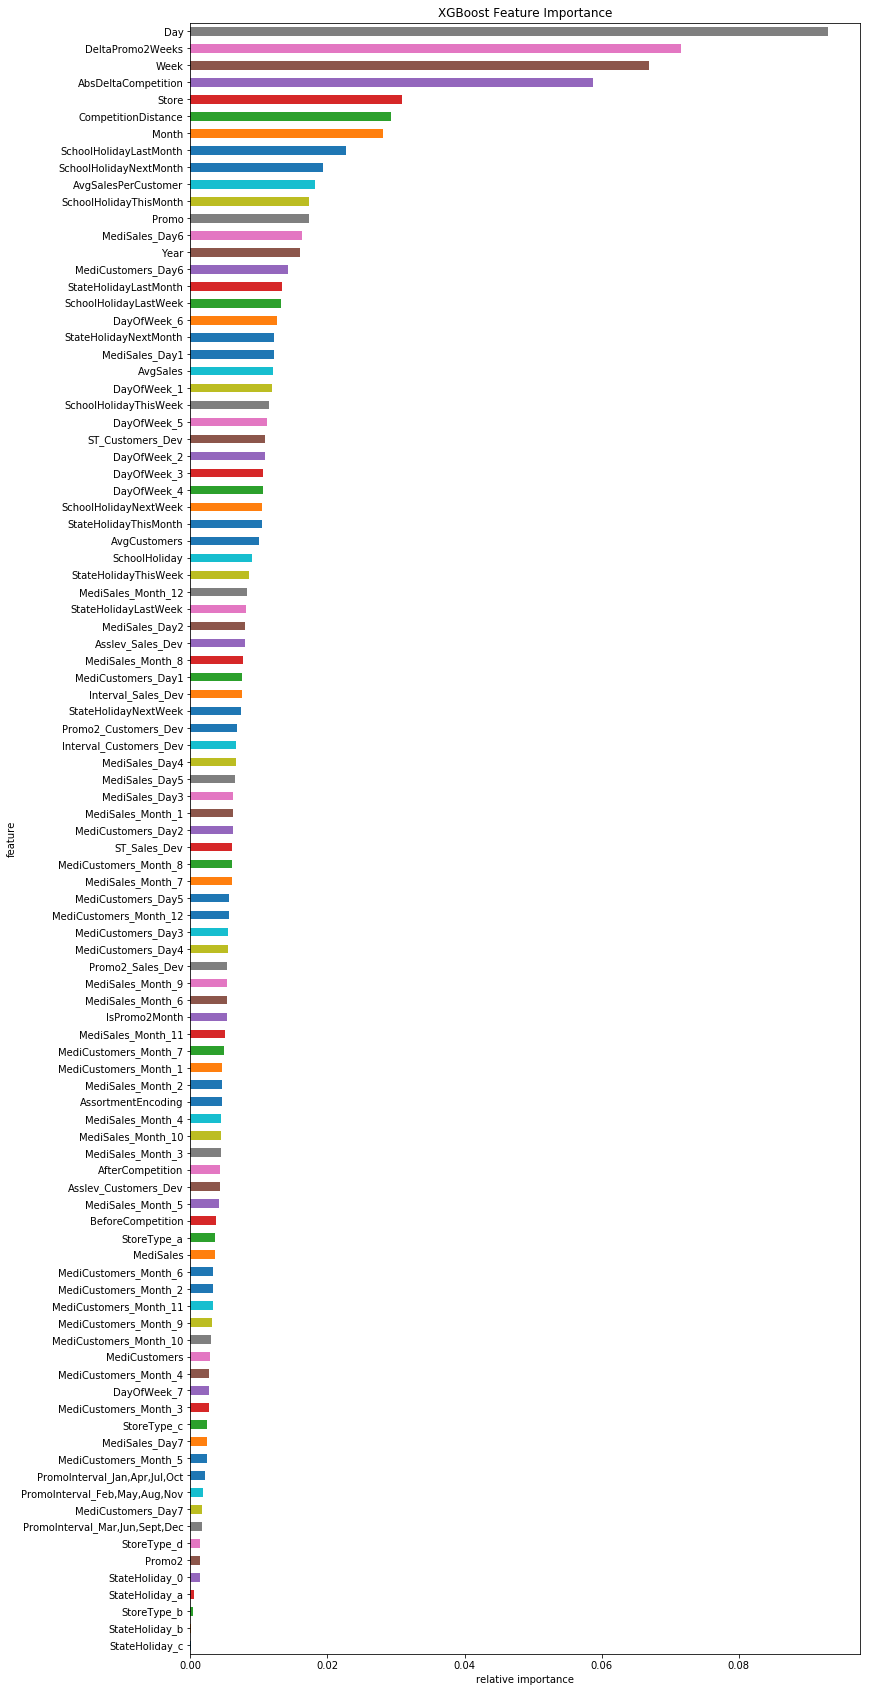

In [21]:
featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(12, 30))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [27]:
print("Make predictions on the test set")
test_probs = gbm.predict(dtest)
indices = test_probs < 0
test_probs[indices] = 0
test_id_int=[int(i) for i in test_id]
submission = pd.DataFrame({"Id": test_id_int, "Sales": np.exp(test_probs) - 1})
submission['Sales']=submission['Sales']*0.965

Make predictions on the test set


In [28]:
submission.to_csv("submission_partial_para_9.csv", index=False)

In [29]:
#观察模型在验证集上的预测情况
print("Make predictions on the validation set")
val_probs = gbm.predict(dvalid)
indices = val_probs < 0
val_probs[indices] = 0

Make predictions on the validation set


In [30]:
val_preds_df=pd.DataFrame({"Pred_Sales": (np.exp(val_probs) - 1)*0.965})

In [36]:
val_all_combined=pd.merge(val_all,val_preds_df,left_index=True,right_index=True,how='left')

In [43]:
val_all_combined['Date']=val_all_combined['Year'].map(str)+ '-0' + val_all_combined['Month'].map(str)+'-'+val_all_combined['Day'].map(str)

In [45]:
val_all_combined=val_all_combined[['Date','Store','Sales','Pred_Sales']]

In [53]:
val_all_combined['Date']= val_all_combined['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [58]:
#查看1100号店铺的验证集预测情况
data_1100=val_all_combined[val_all_combined['Store']==1100]
data_1100=data_1100.sort_values(by='Date',ascending=True)
data_1100=data_1100.set_index(data_1100['Date'],drop=True)

In [68]:
#查看30号店铺的验证集预测情况
data_1111=val_all_combined[val_all_combined['Store']==1111]
data_1111=data_1111.sort_values(by='Date',ascending=True)
data_1111=data_1111.set_index(data_1111['Date'],drop=True)

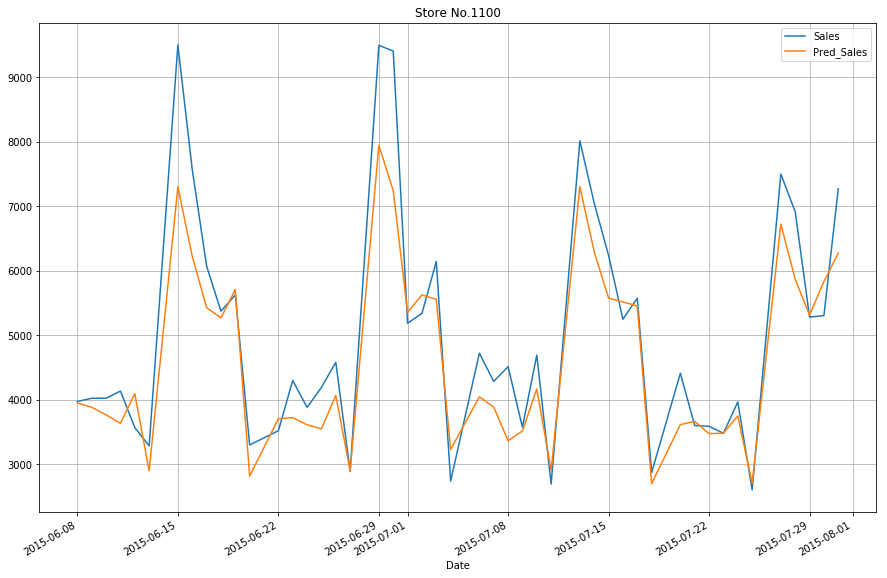

In [65]:
data_1100[['Sales','Pred_Sales']].plot(legend=True,grid=True,figsize=(15,10),title='Store No.1100')

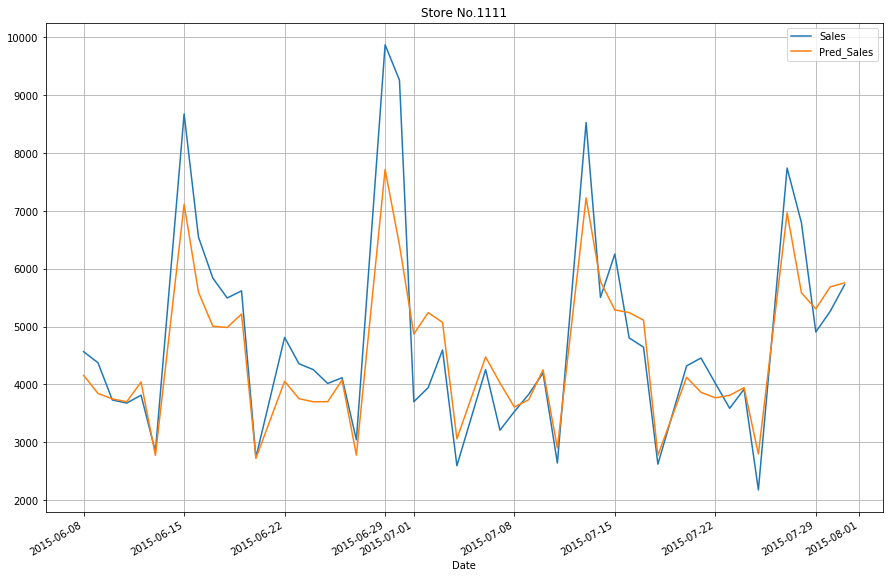

In [69]:
data_1111[['Sales','Pred_Sales']].plot(legend=True,grid=True,figsize=(15,10),title='Store No.1111')